In [45]:
import requests
import os
from typing import TypedDict, List, Dict, Optional
from langgraph.graph import StateGraph, END
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage, ToolMessage
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from typing_extensions import Annotated
from IPython.display import Markdown, Image, display
from dotenv import dotenv_values


In [46]:
from typing_extensions import Annotated

def merge_lists(left: list | None, right: list | None) -> list:
    """Safely merge two lists, even if one is None."""
    return (left or []) + (right or [])

class TravelGraphState(TypedDict):
    flight_status: Annotated[list[dict], merge_lists]  
    hotel_status: Annotated[list[dict], merge_lists]   
    booking_status: Annotated[list[dict], merge_lists] 
    weather_status: Annotated[list[dict], merge_lists] 
    memory: Annotated[list[str], merge_lists]         


In [ ]:



def fetch_flight_status(state: TravelGraphState) -> TravelGraphState:
    """Simulate fetching flight status."""
    state["flight_status"] = [{"flight": "AI-202", "status": "Delayed"}]
    return state

def fetch_hotel_availability(state: TravelGraphState) -> TravelGraphState:
    """Simulate fetching hotel availability."""
    state["hotel_status"] = [{"hotel": "Hilton", "status": "Fully Booked"}]
    return state

def fetch_booking_status(state: TravelGraphState) -> TravelGraphState:
    """Simulate fetching booking status."""
    state["booking_status"] = [{"reference": "BKG-12345", "status": "Cancelled"}]
    return state


def fetch_weather_status(state: TravelGraphState) -> TravelGraphState:
    """Fetch weather information using an API and update the state."""
    city = state.get("city", "Bangalore")  
    API_KEY = env_values['WEATHERAPI_KEY']

    if not API_KEY:
        state["weather_status"] = [{"city": city, "condition": "Unknown", "temperature": "N/A"}]
        return state

    URL = f"http://api.weatherapi.com/v1/current.json?key={API_KEY}&q={city}&aqi=no"
    response = requests.get(URL)

    if response.status_code == 200:
        data = response.json()
        state["weather_status"] = [{
            "city": city,
            "condition": data["current"]["condition"]["text"],
            "temperature": data["current"]["temp_c"],
        }]
    else:
        state["weather_status"] = [{"city": city, "condition": "Unknown", "temperature": "N/A"}]

    return state



In [48]:
def store_memory(state: TravelGraphState, store: BaseStore, config: RunnableConfig) -> TravelGraphState:
    user_id = config.get("configurable", {}).get("user_id", "default_user")  
    namespace = ("memory", user_id)
  
    memory_updates = []  

    for flight in state.get("flight_status", []):
        if flight.get("status") in ["Delayed", "Cancelled"]:
            alert = f"{flight['status']} - {flight['flight']}"
            store.put(namespace, "Flight Alert", alert)
            memory_updates.append(alert)

    for booking in state.get("booking_status", []):
        if booking.get("status") == "Cancelled":
            alert = f"{booking['reference']} was cancelled!"
            store.put(namespace, "Booking Alert", alert)
            memory_updates.append(alert)

    for hotel in state.get("hotel_status", []):
        if hotel.get("status") == "Fully Booked":
            alert = f"{hotel['hotel']} has no available rooms!"
            store.put(namespace, "Hotel Alert", alert)
            memory_updates.append(alert)

    for weather in state.get("weather_status", []):
        if weather.get("condition") in ["Thunderstorm", "Heavy Rain", "Extreme Heat"]:
            alert = f"Severe weather in {weather['city']}: {weather['condition']}"
            store.put(namespace, "Weather Alert", alert)
            memory_updates.append(alert)

    state["memory"] = merge_lists(state.get("memory", []), memory_updates)
    return state


In [49]:
class TravelAlertAgent:
    def __init__(self):
        builder = StateGraph(TravelGraphState)
        self.store = InMemoryStore() 

        builder.add_node("start", lambda state: state)
        builder.add_node("fetch_flight_status", fetch_flight_status)
        builder.add_node("fetch_hotel_availability", fetch_hotel_availability)
        builder.add_node("fetch_booking_status", fetch_booking_status)
        builder.add_node("fetch_weather_status", fetch_weather_status)

       
        builder.add_node("memory_store", lambda state, config: store_memory(state, agent.store, config))


        builder.set_entry_point("start")

        builder.add_edge("start", "fetch_flight_status")
        builder.add_edge("start", "fetch_hotel_availability")
        builder.add_edge("start", "fetch_booking_status")
        builder.add_edge("start", "fetch_weather_status")

        builder.add_edge("fetch_flight_status", "memory_store")
        builder.add_edge("fetch_hotel_availability", "memory_store")
        builder.add_edge("fetch_booking_status", "memory_store")
        builder.add_edge("fetch_weather_status", "memory_store")
        builder.add_edge("memory_store", END)

        self.graph = builder.compile()

    def run(self):
        initial_state = {
            "flight_status": [],
            "hotel_status": [],
            "booking_status": [],
            "weather_status": [],
            "city": "Bangalore",
        }
        config = {"configurable": {"user_id": "user_123"}}  

        final_state = self.graph.invoke(initial_state, config=config)  
        return final_state


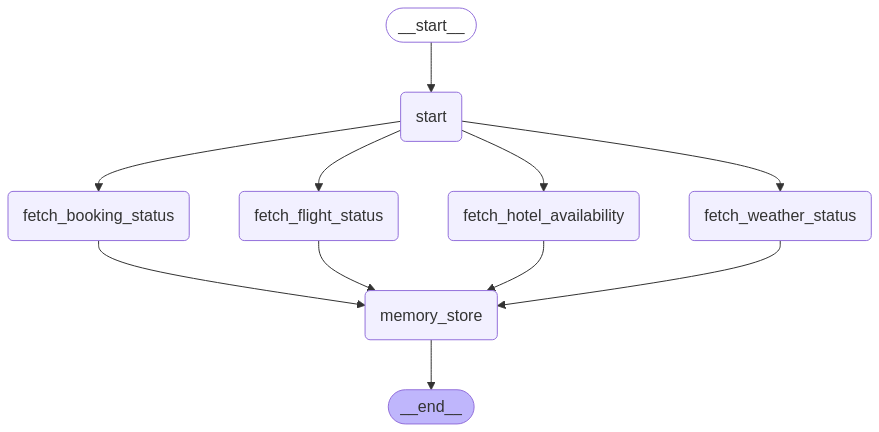

In [50]:
memory = MemorySaver()
agent=TravelAlertAgent()
display(Image(agent.graph.get_graph().draw_mermaid_png()))

In [51]:
agent = TravelAlertAgent()
result = agent.run()
print(result)

{'flight_status': [{'flight': 'AI-202', 'status': 'Delayed'}, {'flight': 'AI-202', 'status': 'Delayed'}], 'hotel_status': [{'hotel': 'Hilton', 'status': 'Fully Booked'}, {'hotel': 'Hilton', 'status': 'Fully Booked'}], 'booking_status': [{'reference': 'BKG-12345', 'status': 'Cancelled'}, {'reference': 'BKG-12345', 'status': 'Cancelled'}], 'weather_status': [{'city': 'Bangalore', 'condition': 'Partly cloudy', 'temperature': 34.4}, {'city': 'Bangalore', 'condition': 'Partly cloudy', 'temperature': 34.4}], 'memory': ['Delayed - AI-202', 'BKG-12345 was cancelled!', 'Hilton has no available rooms!']}
